# Amplitude-based kNN for 2 dimensional vectors

We will start with quantum states composed of 2 qubits, then we will generalise the process for N qubits

In [3]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.11.1',
 'qiskit-terra': '0.8.2',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.3',
 'qiskit-ibmq-provider': '0.3.1',
 'qiskit-aqua': '0.5.3'}

In [4]:
from qiskit import IBMQ
provider = IBMQ.load_account()

In [5]:
print("Available backends:")
provider.backends()

Available backends:


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [6]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > 8 and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmq_16_melbourne


In [310]:
import numpy as np
import pandas as pd
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram

In [8]:
# The multi-controlled RY is not included in the standard gates
import qiskit.aqua.circuits.gates.controlled_ry_gates

# Initial state preparation

The algorithm starts with the assumption that the following initial state can be constructed from $M$ training vectors with $N$ entries: 
$$|\psi_0> = \frac{1}{\sqrt{2M}} \sum_{m=1}^M \big(|0>|\psi_x> + |1>|\psi_{t^m}>\big) |c^m> |m> $$

## Build the base circuit

$$|\chi_0> = |a> |d> |c> |m> = |00>|00>|0>|0>$$

In [979]:
knna = QuantumRegister(1, 'knna') # Ancilla for kNN
qrama = QuantumRegister(3, 'qrama') # Ancilla for QRAM
d = QuantumRegister(2, 'd') # Data vectors
r = QuantumRegister(1, 'r') # Rotation register for QRAM
c = QuantumRegister(1, 'class') # Class for kNN
m = QuantumRegister(1, 'm') # Index for kNN
classical = ClassicalRegister(3, 'classic')
circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)

The sum over $m$ is introduced by simply acting an H gate on the $m$ qubit
$$|\chi_1> = (\mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1} \otimes H) |0>|0>|0>|0> = \frac{1}{\sqrt{2}} \sum_{m=0}^1 |0>|0>|0>|m>$$

Using another H gate, the ancilla qubit is put in superposition: 
$$|\chi_2> = (H \otimes \mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1}) |\chi_1> = \frac{1}{2} \sum_{m=0}^1 \big[|0>|0> + |1>|0>\big]|0>|m>$$

Next, the input vector $|\psi_x>$ should be loaded into the quantum state by means of QRAM construction
$$|\chi_3> = QRAM(x) |\chi_2>$$

In [980]:
circuit.h(m)
circuit.h(knna)
circuit.h(d)
circuit.h(c)

In [1033]:
setosa=pd.Series([5.1, 3.5, 1.4, 0.2])
versicolor=pd.Series([7.0, 3.2, 4.7, 1.4])
virginica=pd.Series([6.3, 3.3, 6.0, 2.5])

In [1034]:
setosa -= setosa.mean()
setosa

0    2.55
1    0.95
2   -1.15
3   -2.35
dtype: float64

In [1035]:
versicolor -= versicolor.mean()
versicolor

0    2.925
1   -0.875
2    0.625
3   -2.675
dtype: float64

In [1036]:
virginica -= virginica.mean()
virginica

0    1.775
1   -1.225
2    1.475
3   -2.025
dtype: float64

In [1037]:
max_norm = np.linalg.norm(versicolor)

In [1038]:
def normalize(v):
    # norm=np.linalg.norm(v, ord=1)
    norm = max_norm
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [1039]:
np.linalg.norm(setosa)

3.7749172176353745

In [1040]:
np.linalg.norm(versicolor)

4.107006208906921

In [1041]:
np.linalg.norm(virginica)

3.305676935213119

In [1042]:
setosa = normalize(setosa)
versicolor = normalize(versicolor)
virginica = normalize(virginica)

setosa=setosa.apply(np.abs).apply(np.sqrt).apply(np.arcsin)
versicolor=versicolor.apply(np.sqrt).apply(np.arcsin)
virginica=virginica.apply(np.sqrt).apply(np.arcsin)

In [1043]:
setosa

0    0.907498
1    0.501737
2    0.557609
3    0.857844
dtype: float64

In [1026]:
versicolor

0    1.004545
1         NaN
2    0.400742
3         NaN
dtype: float64

In [1027]:
virginica

0    0.717377
1         NaN
2    0.642608
3         NaN
dtype: float64

In [1028]:
# inputVector = [np.pi/2,0,0,0] 
# trainingVector0 = [np.pi/2,0,0,0]
# trainingVector1 = [0,np.pi/2,0,0]

In [1029]:
inputVector = setosa
trainingVector0 = setosa
trainingVector1 = versicolor

In [996]:
# Begin QRAM state construction for two qubit data
psixCircuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψx state to the |0> state of the kNN ancilla

psixCircuit.x(knna)

# Encode state |00>
psixCircuit.x(d)
psixCircuit.mcry(inputVector[0], d[:] + knna[:], r[0], qrama)
psixCircuit.x(d)

# Encode state |01>
psixCircuit.x(d[1])
psixCircuit.mcry(inputVector[1], d[:] + knna[:], r[0], qrama)
psixCircuit.x(d[1])

# Encode state |10>
psixCircuit.x(d[0])
psixCircuit.mcry(inputVector[2], d[:] + knna[:], r[0], qrama)
psixCircuit.x(d[0])

# Encode state |11>
psixCircuit.mcry(inputVector[3], d[:] + knna[:], r[0], qrama)

# Switch entanglement with ancilla to |a> = |0>
psixCircuit.x(knna)

$$|\chi_3> = \frac{1}{2} \sum_{m=0}^1 \big[ |0>|\psi_x> + |1>|00> \big] |0> |m>$$

The next step is to entangle the first training vector $|\psi_{t^0}>$ with the $|1>$ state of the ancilla and the $|0>$ state of the $m$ qubit. Additionally, the second training vector $\psi_{t^1}$ should be entangled with the $|1>$ states of the ancilla and of the $m$ qubit. 

In [997]:
# Begin QRAM state construction for two qubit data
psit0Circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψt0 state to the |1> state of the kNN ancilla, to the |0> state of m and to the |0> state of c
# Do I need to superposition |d> again? I don't think so
# I also need to entangle the class of the training vector; that should be encoded in the classical vector

psit0Circuit.x(m)
psit0Circuit.x(c)

# Encode state |00>
psit0Circuit.x(d)
psit0Circuit.mcry(trainingVector0[0], d[:] + knna[:] + m[:] + c[:], r[0], qrama)
psit0Circuit.x(d)

# Encode state |01>
psit0Circuit.x(d[1])
psit0Circuit.mcry(trainingVector0[1], d[:] + knna[:] + m[:] + c[:], r[0], qrama)
psit0Circuit.x(d[1])

# Encode state |10>
psit0Circuit.x(d[0])
psit0Circuit.mcry(trainingVector0[2], d[:] + knna[:] + m[:] + c[:], r[0], qrama)
psit0Circuit.x(d[0])

# Encode state |11>
psit0Circuit.mcry(trainingVector0[3], d[:] + knna[:] + m[:] + c[:], r[0], qrama)

# Switch entanglement with m to |m> = |0>
psit0Circuit.x(m)
# Switch entanglement with c to |c> = |0>
psit0Circuit.x(c)

In [998]:
# Begin QRAM state construction for two qubit data
psit1Circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψt1 state to the |1> state of the kNN ancilla, to the |1> state of m and to the |1> state of c

# Encode state |00>
psit1Circuit.x(d)
psit1Circuit.mcry(trainingVector1[0], d[:] + knna[:] + m[:] + c[:], r[0], qrama)
psit1Circuit.x(d)

# Encode state |01>
psit1Circuit.x(d[1])
psit1Circuit.mcry(trainingVector1[1], d[:] + knna[:] + m[:] + c[:], r[0], qrama)
psit1Circuit.x(d[1])

# Encode state |10>
psit1Circuit.x(d[0])
psit1Circuit.mcry(trainingVector1[2], d[:] + knna[:] + m[:] + c[:], r[0], qrama)
psit1Circuit.x(d[0])

# Encode state |11>
psit1Circuit.mcry(trainingVector1[3], d[:] + knna[:] + m[:] + c[:], r[0], qrama)

In [999]:
circuit += psixCircuit
circuit += psit0Circuit
circuit += psit1Circuit

The desired input and training state is obtained after post-selecting the measurement outcome $|1>_R$ on the register qubit.

In [1000]:
circuit.measure(r,classical[0])
circuit.h(knna)
circuit.measure(knna,classical[1])
circuit.measure(c,classical[2])

Having prepared the initial state $|\psi_0>$ one has to simply apply an H gate to the ancilla qubit. This causes the aplitudes of $|\psi_x>$ and $|\psi_{t^m}>$ to interfere. In this case, constructive ($+$) interference happens when the ancilla qubit is $|0>$ and destructive ($-$) interference when the ancilla is $|1>$. 

After the successful conditional measurement, the state is proportional to:
$$|\psi_2> = \frac{1}{2\sqrt{M}} \sum_{m=0}^1 \sum_{i=0}^3 (x_i + t_i^m) |0> |i> |c^m> |m>$$

The probability of measuring e.g. class $|1>$ (B) is then given by the following expression:
$$\text{Prob}(|c^m> = |1(\text{B})>) = \sum_{m|c^m=1(\text{B})} 1 - \frac{1}{4M} \sum_{i=0}^3 |x_i - t_i^m|^2$$

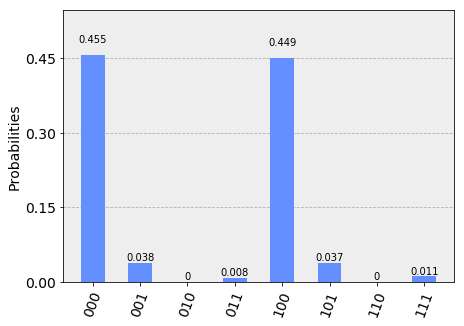

In [1011]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=32768)
result = job.result()
counts = result.get_counts(circuit)
# print("\nTotal counts are:",counts)
plot_histogram(counts)

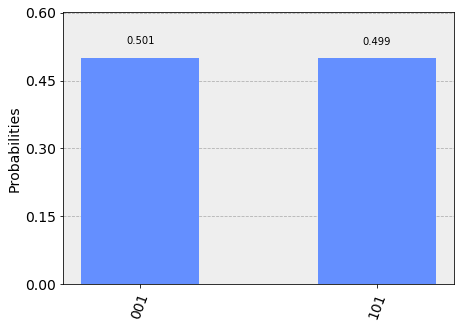

In [1012]:
goodCounts = {k: counts[k] for k in counts.keys() & {'001', '101'}}
plot_histogram(goodCounts)
# limit: 0.550

In [403]:
# from qiskit.tools.monitor import job_monitor
# # Number of shots to run the program (experiment);
# # maximum is 8192 shots.
# shots = 1024
# # Maximum number of credits to spend on executions.
# max_credits = 3

# job_exp = execute(circuit, backend, shots=shots, max_credits=max_credits)
# job_monitor(job_exp)

In [404]:
# result_exp = job_exp.result()

In [405]:
# counts_exp = result_exp.get_counts(circuit)

In [78]:
# goodCounts_exp = {k: counts_exp[k] for k in counts_exp.keys() & {'001', '101'}}

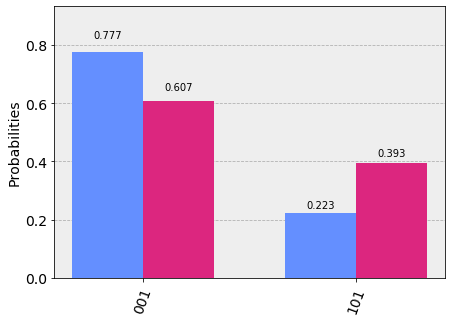

In [107]:
plot_histogram([goodCounts_exp,goodCounts])
# Id 5d3f135109d4990018c3984a
# The experimental results are much better than the simulation results

In [25]:
# # Testing QRAM
# inputVector = [np.pi,np.pi,np.pi,0]
# qram = QuantumCircuit(qrama,d,r,classical)
# # I need to entangle the ψx state to the |0> state of the kNN ancilla
# qram.h(d)
# # Encode state |00>
# qram.x(d)
# # The rotation angle should be converted accordingly
# qram.mcry(inputVector[0], d[0:2], r[0], qrama)
# qram.x(d)
# qram.barrier()
# # Encode state |01>
# qram.x(d[0])
# qram.mcry(inputVector[1], d[0:2], r[0], qrama)
# qram.x(d[0])
# qram.barrier()
# # Encode state |10>
# qram.x(d[1])
# qram.mcry(inputVector[2], d[0:2], r[0], qrama)
# qram.x(d[1])
# qram.barrier()
# # Encode state |11>
# qram.mcry(inputVector[3], d[0:2], r[0], qrama)
# qram.barrier()
# # qram.draw(output='mpl')
# qram.measure(r,classical[0])
# simulator = Aer.get_backend('qasm_simulator')
# job = execute(qram, simulator, shots=2000)
# result = job.result()
# counts = result.get_counts(qram)
# print("\nTotal counts are:",counts)